In [50]:
#!pip install langchain_groq
#!pip install matplotlib

In [57]:
from langchain_openai import ChatOpenAI
from typing import Annotated, List, Tuple, Union
from langchain.tools import BaseTool, StructuredTool, Tool
from langchain_experimental.tools import PythonREPLTool
from langchain_core.tools import tool
from langchain_groq import ChatGroq
import random
import os

#os.environ["OPENAI_API_KEY"] = "[token]"
#llm = ChatOpenAI(model="gpt-3.5-turbo")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "[token]"
os.environ["LANGCHAIN_PROJECT"] = "pr-teste-lang-grapth"

llm = ChatGroq(temperature=0, groq_api_key="[token]", model_name="llama3-70b-8192")

#Tools
#for plotting the diagram
python_repl_tool = PythonREPLTool()

#for generating random numbers
@tool("random_number", return_direct=False)
def random_number(input:str) -> str:
    """Returns a random number between 0-100. input the word 'random'"""
    return random.randint(0, 100)

tools = [random_number,python_repl_tool]

In [58]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI

# function that returns AgentExecutor with given tool and prompt
def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

# agent node, funtion that we will use to call agents in our graph
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

In [59]:
import operator
from typing import Annotated, Any, Dict, List, Optional, Sequence, TypedDict
import functools
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END

# Random_Number_Generator as a node
random_agent = create_agent(llm, [random_number], "You get random numbers")
random_node = functools.partial(agent_node, agent=random_agent, name="Random_Number_Generator")

# Coder as a node
code_agent = create_agent(llm, [python_repl_tool], "You generate charts using matplotlib.")
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

In [60]:
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

members = ["Random_Number_Generator", "Coder"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
# It will use function calling to choose the next worker node OR finish processing.
options = ["FINISH"] + members
# openai function calling 
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))


# we create the chain with llm binded with routing function + system_prompt
supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

In [61]:
# defining the AgentState that holds messages and where to go next
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str

# defining the StateGraph
workflow = StateGraph(AgentState)

# agents as a node, supervisor_chain as a node 
workflow.add_node("Random_Number_Generator", random_node)
workflow.add_node("Coder", code_node)
workflow.add_node("supervisor", supervisor_chain)

# when agents are done with the task, next one should be supervisor ALWAYS
workflow.add_edge("Random_Number_Generator", "supervisor") 
workflow.add_edge("Coder", "supervisor")

# Supervisor decides the "next" field in the graph state, 
# which routes to a node or finishes. (Remember the special node END above)
workflow.add_conditional_edges(
                    "supervisor", 
                    lambda x: x["next"], 
                    {
                       "Random_Number_Generator": "Random_Number_Generator",
                       "Coder": "Coder",
                       "FINISH": END 
                    })

# starting point should be supervisor
workflow.set_entry_point("supervisor")


graph = workflow.compile()

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"

{'supervisor': {'next': 'Random_Number_Generator'}}
----


HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"

{'Random_Number_Generator': {'messages': [HumanMessage(content='Here is the histogram of the 10 random numbers:\n\n```\n 0-10: ***\n11-20:\n21-30: *\n31-40: *\n41-50: **\n51-60: *\n61-70:\n71-80:\n81-90:\n91-100: **\n```\n\nLet me know if you need anything else!', name='Random_Number_Generator')]}}
----


HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"

Retrying request to /openai/v1/chat/completions in 1.000000 seconds

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"

{'supervisor': {'next': 'Coder'}}
----


HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"

Retrying request to /openai/v1/chat/completions in 8.000000 seconds

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"

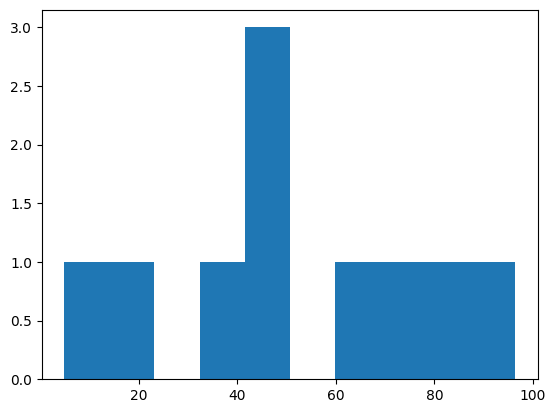

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"

Retrying request to /openai/v1/chat/completions in 10.000000 seconds

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"

Retrying request to /openai/v1/chat/completions in 11.000000 seconds

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"

{'Coder': {'messages': [HumanMessage(content="The histogram has been saved as an image. I'll assume it's been shared with me. If you'd like to describe the histogram or ask a question about it, I'm here to help!", name='Coder')]}}
----


HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"

Retrying request to /openai/v1/chat/completions in 13.000000 seconds

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"

{'supervisor': {'next': 'Coder'}}
----


HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"

Retrying request to /openai/v1/chat/completions in 9.000000 seconds

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"

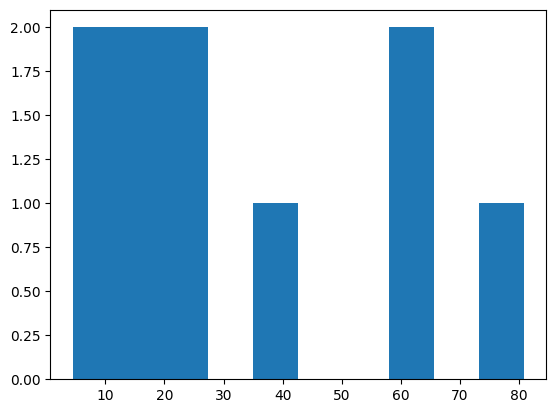

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"

Retrying request to /openai/v1/chat/completions in 10.000000 seconds

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"

Retrying request to /openai/v1/chat/completions in 12.000000 seconds

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"

{'Coder': {'messages': [HumanMessage(content="I'd like to describe the histogram. Can you tell me what it looks like?", name='Coder')]}}
----


HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"

Retrying request to /openai/v1/chat/completions in 11.000000 seconds

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"

{'supervisor': {'next': 'Coder'}}
----


HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"

Retrying request to /openai/v1/chat/completions in 10.000000 seconds

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"

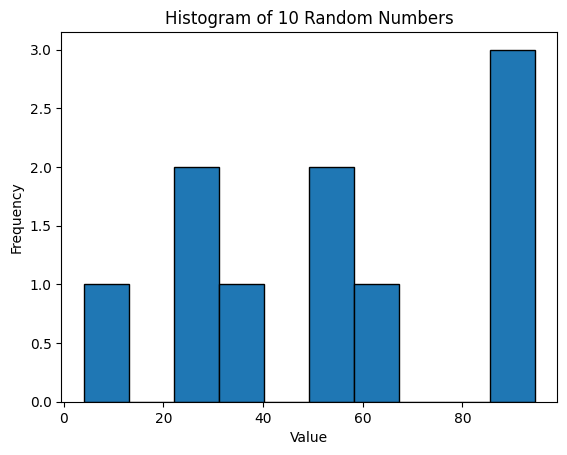

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"

Retrying request to /openai/v1/chat/completions in 11.000000 seconds

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"

Retrying request to /openai/v1/chat/completions in 12.000000 seconds

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [62]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Get 10 random numbers and generate a histogram")
        ]
    }, config={"recursion_limit": 6}
):
    if "__end__" not in s:
        print(s)
        print("----")